In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from astropy import wcs
from astropy.io import fits

In [42]:
def load_cat(filename):

    return pd.read_csv(filename, sep=r'\s+', skiprows=5, header=None, names=["ra", "dec",
            "flux", "flux_err"])

In [43]:
hdulB = fits.open("data/coadd.fits")
hduB = hdulB[0]
imageB = hduB.data.T

In [44]:
hdulV = fits.open("data/coadd_V.fits")
hduV = hdulV[0]
imageV = hduV.data.T

In [45]:
# Bounds on viewing windows
ylo_B, yhi_B = 675, 925
xlo_B, xhi_B = 325, 825
ylo_V, yhi_V = 575, 825
xlo_V, xhi_V = 325, 825

In [46]:
def plot_galaxy_B():
    
    plt.imshow(imageB[ylo_B:yhi_B, xlo_B:xhi_B], cmap="magma", vmin=0.045, vmax=0.05)
    plt.colorbar()
    
def plot_galaxy_V():
    
    plt.imshow(imageV[ylo_V:yhi_V, xlo_V:xhi_V], cmap="magma", vmin=0.094,vmax=0.105)
    plt.colorbar()

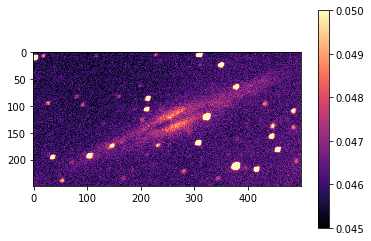

In [47]:
plot_galaxy_B()

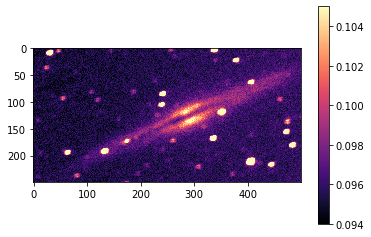

In [48]:
plot_galaxy_V()

In [49]:
warnings.filterwarnings('ignore', category=wcs.FITSFixedWarning)

In [50]:
cat_B = load_cat("data/B_gal.cat")
cat_B.sort_values(by="flux", ascending=False, inplace=True)
w_B = wcs.WCS(hduB.header)
starwcs_B = np.stack((cat_B["ra"], cat_B["dec"])).T

In [51]:
cat_V = load_cat("data/V_gal.cat")
cat_V.sort_values(by="flux", ascending=False, inplace=True)
w_V = wcs.WCS(hduV.header)
starwcs_V = np.stack((cat_B["ra"], cat_B["dec"])).T

In [52]:
starpix_B = w_B.wcs_world2pix(starwcs_B, 0)
starpix_V = w_V.wcs_world2pix(starwcs_V, 0)

In [53]:
indx_B = np.indices(imageB.shape)
pix_B = np.stack((indx_B[0].flatten(), indx_B[1].flatten())).T

indx_V = np.indices(imageV.shape)
pix_V = np.stack((indx_V[0].flatten(), indx_V[1].flatten())).T

In [54]:
for pair in starpix_B:
    
    dist = np.sqrt(((pix_B - pair)**2).sum(axis=1))
    inradius = pix_B[dist < 9.6].T
    imageB[inradius[0], inradius[1]] = 0.0

In [55]:
for pair in starpix_V:
    
    dist = np.sqrt(((pix_V - pair)**2).sum(axis=1))
    inradius = pix_V[dist < 9.6].T
    imageV[inradius[0], inradius[1]] = 0.0

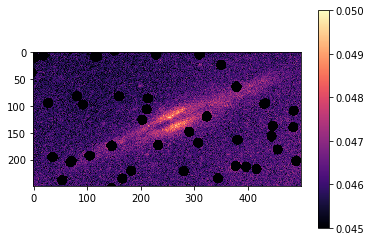

In [56]:
plot_galaxy_B()

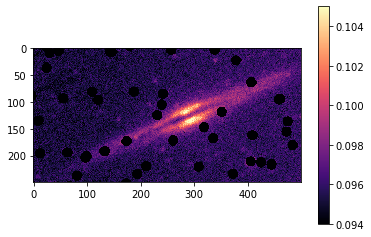

In [57]:
plot_galaxy_V()

In [58]:
def parx(t, x0, y0, a, b, theta):
    
    return a*np.cos(t)*np.cos(theta) - b*np.sin(t)*np.sin(theta) + x0

def pary(t, x0, y0, a, b, theta):
    
    return a*np.cos(t)*np.sin(theta) + b*np.sin(t)*np.cos(theta) + y0

def plot_ellipse(x0, y0, a, b, theta):
    
    t = np.linspace(0, 2*np.pi)
    x = parx(t, x0, y0, a, b, theta)
    y = pary(t, x0, y0, a, b, theta)
    plt.plot(x, y, color="deepskyblue")

In [59]:
a, b, theta = 220, 22, -0.13 * np.pi
x0_B, y0_B = 263, 125
x0_V, y0_V = 279, 132

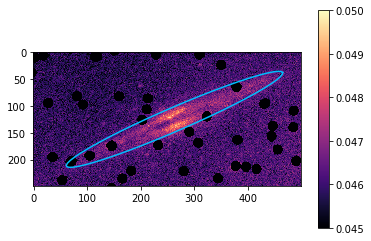

In [60]:
plot_galaxy_B()
plot_ellipse(x0_B, y0_B, a, b, theta)

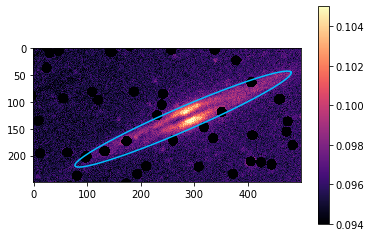

In [61]:
plot_galaxy_V()
plot_ellipse(x0_V, y0_V, a, b, theta)

In [62]:
def inside_ellipse(x, y, *par):
    
    x0, y0, a, b, theta = par
    
    t = np.linspace(0, 2*np.pi, num=10000)
    x_t = parx(t, x0, y0, a, b, theta)
    y_t = pary(t, x0, y0, a, b, theta)
    
    dx = np.abs(x_t - x)
    dy = np.abs(y_t - y)
    
    i1 = np.argmin(dx)
    j1 = np.argmin(dy)
    
    dx[i1] = float("inf")
    dy[j1] = float("inf")
    
    i2 = np.argmin(dx)
    j2 = np.argmin(dy)
    
    x1, x2 = sorted([x_t[j1], x_t[j2]])
    y1, y2 = sorted([y_t[i1], y_t[i2]])
    
    inside  = x1 <= x <= x2
    inside &= y1 <= y <= y2
    return inside

In [63]:
x_B = pix_B.T[1].reshape(imageB.shape)[ylo_B:yhi_B, xlo_B:xhi_B] - xlo_B
y_B = pix_B.T[0].reshape(imageB.shape)[ylo_B:yhi_B, xlo_B:xhi_B] - ylo_B
y_B = y_B[::-1]

x_V = pix_V.T[1].reshape(imageV.shape)[ylo_V:yhi_V, xlo_V:xhi_V] - xlo_V
y_V = pix_V.T[0].reshape(imageV.shape)[ylo_V:yhi_V, xlo_V:xhi_V] - ylo_V
y_V = y_V[::-1]

In [64]:
def indices_in_ellipse(x, y, *par):
    
    imax, jmax = x.shape

    for i in range(imax):
        for j in range(jmax):
            if inside_ellipse(x[i][j], y[i][j], *par):
                yield i, j

In [65]:
indx_gen = indices_in_ellipse(x_B, y_B, x0_B, y0_B, a, b, theta)
ind_dim1_B, ind_dim2_B = np.array(list(indx_gen)).T
ind_dim1_B += ylo_B
ind_dim2_B += xlo_B

In [66]:
bgB = np.copy(imageB)
bgB[ind_dim1_B, ind_dim2_B] = 0.0
bgB = bgB.mean()
bgB

0.03260172

In [76]:
imageB -= bgB

In [77]:
flux_B = imageB[ind_dim1_B, ind_dim2_B].sum()
flux_B

135.88486

In [68]:
indx_gen = indices_in_ellipse(x_V, y_V, x0_V, y0_V, a, b, theta)
ind_dim1_V, ind_dim2_V = np.array(list(indx_gen)).T
ind_dim1_V += ylo_V
ind_dim2_V += xlo_V

In [75]:
bgV = np.copy(imageV)
bgV[ind_dim1_V, ind_dim2_V] = 0.0
bgV = bgV.mean()
bgV

0.067262985

In [78]:
imageV -= bgV

In [79]:
flux_V = imageV[ind_dim1_V, ind_dim2_V].sum()
flux_V

296.16705

In [80]:
b_minus_v = -2.5*np.log10(flux_B/flux_V)
b_minus_v

0.8459141850471497

In [81]:
d_gal = 27.3 # Mly

In [82]:
def distances(starcoords, catframe):
    
    alpha, delta = starcoords
    dra = (alpha - catframe['ra']) * np.cos(delta)
    ddec = delta - catframe['dec']
    return np.sqrt(dra**2 + ddec**2)
    
def fuzzy_match(starcoords, catframe):
    
    gamma = distances(starcoords, catframe)
    indx = gamma.idxmin()
    
    return catframe.loc[indx]

In [83]:
starcoords = 35.590435, 42.396332
ref_row = fuzzy_match(starcoords, cat_V)
flux_ref = ref_row['flux']
mag_ref = 10.81

In [84]:
mag_gal = mag_ref - 2.5*np.log10(flux_V/flux_ref)
mag_gal

8.288039332099922